#  Обратное распространение ошибки

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* http://cs231n.stanford.edu/handouts/linear-backprop.pdf
* https://www.adityaagrawal.net/blog/deep_learning/bprop_fc
* https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

## Задачи для совместного разбора

1\. Реализуйте обратное распространение ошибки для модели нейрона с квадратичной функцией потерь при условии, что на вход нейрону поступает вектор `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

In [ ]:
inputs = th.tensor([1.0, 2.0, 3.0, 4.0])
y_true = th.tensor([10.0])

weights_manual = th.randn(4)
bias_manual = th.randn(1)

# Forward pass
y_pred_manual = inputs.dot(weights_manual) + bias_manual
loss_manual = (y_pred_manual - y_true)**2

# Backward pass
# dL/dy_pred
grad_loss_pred = 2 * (y_pred_manual - y_true)
# dL/dw = (dL/dy_pred) * (dy_pred/dw)
grad_weights_manual = grad_loss_pred * inputs
# dL/db = (dL/dy_pred) * (dy_pred/db)
grad_bias_manual = grad_loss_pred * 1

print("Градиенты, рассчитанные вручную:")
print(f"dL/dw: {grad_weights_manual}")
print(f"dL/db: {grad_bias_manual}\n")


# с помощью Torch
weights_torch = weights_manual.clone().requires_grad_()
bias_torch = bias_manual.clone().requires_grad_()

# Forward pass
y_pred_torch = inputs.dot(weights_torch) + bias_torch
loss_torch = (y_pred_torch - y_true)**2

# Backward pass
loss_torch.backward()

print("Градиенты, рассчитанные Torch:")
print(f"dL/dw: {weights_torch.grad}")
print(f"dL/db: {bias_torch.grad}\n")

Градиенты, рассчитанные вручную:
dL/dw: tensor([ -45.3372,  -90.6745, -136.0117, -181.3489])
dL/db: tensor([-45.3372])

Градиенты, рассчитанные Torch:
dL/dw: tensor([ -45.3372,  -90.6745, -136.0117, -181.3489])
dL/db: tensor([-45.3372])



2\. Настройте модель нейрона, используя метод стохастического градиентного спуска и собственную реализацию обратного распространения ошибки.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(100, 1)

class Neuron:
    def __init__(self, n_features):
        self.weights = th.randn(n_features, 1)
        self.bias = th.randn(1)

    def forward(self, inputs):
        return inputs @ self.weights + self.bias

In [ ]:
neuron = Neuron(X.size()[1])
lr = 0.1
epoch = 200
losses = []

for i in range(epoch):
    y_preds = neuron.forward(X)
    loss = (y_preds - y).pow(2).mean()
    losses.append(loss.item())
    # Backward pass
    # dL/dy_pred
    grad_loss_pred = 2 * (y_preds - y) / X.size()[0]
    # dL/dw = (dL/dy_pred) * (dy_pred/dw) = (2*(y_pred - y)/N) * X
    grad_weights = X.T @ grad_loss_pred
    # dL/db = (dL/dy_pred) * (dy_pred/db) = (2*(y_pred - y)/N) * 1
    grad_bias = grad_loss_pred.sum()

    neuron.weights -= lr * grad_weights
    neuron.bias -= lr * grad_bias

    if (i + 1) % 20 == 0:
        print(f"Эпоха [{i+1}/{epoch}], Потери: {loss.item():.4f}")

print(f"Обученные веса: {neuron.weights.T}")
print(f"Обученное смещение: {neuron.bias}")

Эпоха [20/200], Потери: 5.8095
Эпоха [40/200], Потери: 0.0069
Эпоха [60/200], Потери: 0.0000
Эпоха [80/200], Потери: 0.0000
Эпоха [100/200], Потери: 0.0000
Эпоха [120/200], Потери: 0.0000
Эпоха [140/200], Потери: 0.0000
Эпоха [160/200], Потери: 0.0000
Эпоха [180/200], Потери: 0.0000
Эпоха [200/200], Потери: 0.0000
Обученные веса: tensor([[ 5.6376, 86.4722, 27.3407, 41.4819]])
Обученное смещение: tensor([0.5000])


In [ ]:
#from sklearn.datasets import make_regression
#import numpy as np
#import matplotlib.pyplot as plt

#X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
#X = th.FloatTensor(X)
#y = th.FloatTensor(y).reshape(100,1)

In [ ]:
#coef

array([ 5.63754967, 86.47223763, 27.34070719, 41.48195023])

In [ ]:
#X.size(), y.size()

(torch.Size([100, 4]), torch.Size([100, 1]))

In [ ]:
#class Neuron:
    #def __init__(self, n_features):
        # <создать атрибуты объекта weights и bias>
        #self.weights = th.randn(n_features)
        #self.bias = th.randn(1)
        #print(self.bias, self.weights)
    #def forward(self, inputs: TensorType["n_features"]) -> Scalar:
        #return inputs.dot(self.weights) + self.bias

In [ ]:
#neuron = Neuron(X.size()[1])

tensor([-0.1215]) tensor([-0.7043,  1.1088,  0.0678,  0.3382])


In [ ]:
#y_preds = neuron.forward(X)
#(y_preds - y).pow(2).mean()

In [ ]:
#lr = 0.1
#epoch = 200
#e = []
#for i in range(0, epoch):
    #forward
    #y_preds = neuron.forward(X)
    #E = (y_preds - y).pow(2).mean()
    #backward
    #dEdw = (2/X.size()[0]) * (y_preds - y) @ X
    #deDb = (2/X.size()[0]) * (y_preds - y) @ th.ones(100)
    #optim
    #neuron.weights -= lr * dEdw
    #neuron.bias -= lr * dEdw
    #loss.backward()

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Реализуйте обратное распространение ошибки для модели нейрона с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{0} \\
w_{1} \\
\vdots \\
w_{m} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$L = \frac{1}{k}\sum_{k}{(\hat{y_k}-y_k)^2}$$

$$\nabla_{\hat{\mathbf{Y}}} L=\begin{bmatrix}
\frac{\partial L}{\partial \hat{y_1}} \\
\frac{\partial L}{\partial \hat{y_2}} \\
\vdots \\
\frac{\partial L}{\partial \hat{y_k}} \\
\end{bmatrix} = \frac{2}{k}\begin{bmatrix}
\hat{y_1} - y_1 \\
\hat{y_2} - y_2 \\
\vdots \\
\hat{y_k} - y_k \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\nabla_{\hat{\mathbf{Y}}} L}$$

- [ ] Проверено на семинаре

In [ ]:
Scalar = TensorType[()]

class NeuronBatch:
    def __init__(self, n_features: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        self.weights: TensorType["n_features_with_bias", 1] = th.randn(n_features + 1, 1, requires_grad=grad)

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        ones = th.ones(inputs.size(0), 1, dtype=inputs.dtype, device=inputs.device)
        return th.cat([inputs, ones], dim=1)

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", 1]:
        X_with_bias = self.add_ones_col(inputs)
        return X_with_bias @ self.weights

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", 1]) -> None:
        X_with_bias = self.add_ones_col(inputs)
        #dL/dW = Xᵀ * dL/dŶ
        self.dweights: TensorType["n_features_with_bias", 1] = X_with_bias.T @ dnext

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", 1], y_true: TensorType["batch", 1]) -> Scalar:
        return ((y_pred - y_true) ** 2).mean()

    def backward(self, y_pred: TensorType["batch", 1], y_true: TensorType["batch", 1]) -> None:
        n = y_pred.size(0)
        # dL/dŶ = (2/n) * (Ŷ - Y)
        self.dinput: TensorType["batch", 1] = (2.0 / n) * (y_pred - y_true)

<p class="task" id="2"></p>

2\. Настройте модель нейрона, используя метод мини-пакетного градиентного спуска.

Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset
import torch as th

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [ ]:
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset
import torch as th
import numpy as np

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

batch_size = 16
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NeuronBatch(n_features=4, seed=123, grad=False)
loss_fn = MSELoss()

learning_rate = 0.01
epochs = 100

for epoch in range(epochs):
    epoch_loss = 0
    for inputs_batch, targets_batch in dataloader:
        y_pred = model.forward(inputs_batch)
        loss = loss_fn.forward(y_pred, targets_batch)
        epoch_loss += loss.item()

        loss_fn.backward(y_pred, targets_batch)
        model.backward(inputs_batch, loss_fn.dinput)

        with th.no_grad():
            model.weights -= learning_rate * model.dweights

    if (epoch + 1) % 20 == 0:
        print(f"Эпоха [{epoch+1}/{epochs}], Средняя ошибка: {epoch_loss/len(dataloader):.4f}")


print("Истинные значения:")
print(f"  Коэффициенты: {np.round(coef, 2)}")
print(f"  Bias: {0.5}")

print("Значения, полученные моделью:")
estimated_coefs = model.weights[:-1, 0].detach().numpy()
estimated_bias = model.weights[-1, 0].item()

print(f"  Оцененные коэффициенты: {np.round(estimated_coefs, 2)}")
print(f"  Оцененный bias: {estimated_bias:.4f}")


Эпоха [20/100], Средняя ошибка: 54.0854
Эпоха [40/100], Средняя ошибка: 0.5934
Эпоха [60/100], Средняя ошибка: 0.0081
Эпоха [80/100], Средняя ошибка: 0.0001
Эпоха [100/100], Средняя ошибка: 0.0000
Истинные значения:
  Коэффициенты: [ 5.64 86.47 27.34 41.48]
  Bias: 0.5
Значения, полученные моделью:
  Оцененные коэффициенты: [ 5.64 86.47 27.34 41.48]
  Оцененный bias: 0.5001


<p class="task" id="3"></p>

3\. Реализуйте обратное распространение ошибки для модели полносвязного слоя с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`.  Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

Обратите внимание, что вам потребуются оба градиента $ \boldsymbol{\nabla_{\mathbf{W}} L }$ и $\boldsymbol{\nabla_{\mathbf{X}} L}$ для распространения ошибки с несколькими слоями.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{01} & w_{02} & \ldots & w_{0n} \\
w_{11} & w_{12} & \ldots & w_{1n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \ldots & w_{mn} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$\nabla_{\hat{\mathbf{Y}}} L = \begin{bmatrix}
\frac{\partial L}{\partial \hat{y_{11}}} & \ldots & \frac{\partial L}{\partial \hat{y_{1n}}} \\
\vdots & \vdots & \vdots \\
\frac{\partial L}{\partial \hat{y_{k1}}} & \ldots & \frac{\partial L}{\partial \hat{y_{kn}}} \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\times \nabla_{\hat{\mathbf{Y}}} L}$$
$$\boldsymbol{\nabla_{\mathbf{X}} L = \nabla_{\hat{\mathbf{Y}}} L\times \mathbf{W}^T}$$

- [ ] Проверено на семинаре

In [ ]:
import torch as th

class Linear:
    def __init__(self, n_features: int, n_neurons: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights: TensorType["n_features_with_bias", "n_neurons"] = ...

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        """Добавляет столбец из единиц в начало матрицы inputs"""
        pass

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_neurons"]:
        pass

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", "n_neurons"]):
        self.dweights: TensorType["n_features_with_bias", "n_neurons"] = ...

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> Scalar:
        pass

    def backward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> None:
        self.dinput: TensorType["batch", "n_neurons"] = ...

In [ ]:
class Linear:
    def __init__(self, n_features: int, n_neurons: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        self.weights: TensorType["n_features_with_bias", "n_neurons"] = th.randn(n_features + 1, n_neurons, requires_grad=grad)

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        ones = th.ones(inputs.size(0), 1, dtype=inputs.dtype, device=inputs.device)
        return th.cat([inputs, ones], dim=1)

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_neurons"]:
        X_with_bias = self.add_ones_col(inputs)
        # (batch, n_features+1) @ (n_features+1, n_neurons)
        return X_with_bias @ self.weights

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", "n_neurons"]):
        X_with_bias = self.add_ones_col(inputs)

        # 1. Градиент по весам: ∇wL = Xᵀ × ∇ŷL
        # (n_features+1, batch) @ (batch, n_neurons)
        self.dweights: TensorType["n_features_with_bias", "n_neurons"] = X_with_bias.T @ dnext

        # 2. Градиент по входам: ∇xL = ∇ŷL × Wᵀ (без bias)
        W_nobias = self.weights[:-1, :]
        # (batch, n_neurons) @ (n_neurons, n_features)
        self.dinput: TensorType["batch", "n_features"] = dnext @ W_nobias.T

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> Scalar:
        return ((y_pred - y_true) ** 2).mean()

    def backward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> None:
        n = y_pred.size(0)
        self.dinput: TensorType["batch", "n_neurons"] = (2.0 / n) * (y_pred - y_true)

<p class="task" id="4"></p>

4\. Настройте полносвязный слой, используя метод пакетного градиентного спуска. Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_regression
import torch as th

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [ ]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

model = Linear(n_features=4, n_neurons=1, seed=42, grad=False)
loss_fn = MSELoss()

learning_rate = 0.01
epochs = 200

for epoch in range(epochs):
    y_pred = model.forward(X)

    loss = loss_fn.forward(y_pred, y)

    loss_fn.backward(y_pred, y)
    model.backward(X, loss_fn.dinput)

    with th.no_grad():
        model.weights -= learning_rate * model.dweights

    if (epoch + 1) % 40 == 0:
        print(f"Эпоха [{epoch+1}/{epochs}], Ошибка: {loss.item():.4f}")


print("Истинные значения:")
print(f"  Коэффициенты: {np.round(coef, 2)}")
print(f"  Bias: {0.5}")

print("\nЗначения, полученные моделью:")
estimated_coefs = model.weights[:-1, 0].detach().numpy()
estimated_bias = model.weights[-1, 0].item()

print(f"  Оцененные коэффициенты: {np.round(estimated_coefs, 2)}")
print(f"  Оцененный bias: {estimated_bias:.4f}")


Эпоха [40/200], Ошибка: 2078.6570
Эпоха [80/200], Ошибка: 463.1152
Эпоха [120/200], Ошибка: 109.5820
Эпоха [160/200], Ошибка: 27.3919
Эпоха [200/200], Ошибка: 7.1690
Истинные значения:
  Коэффициенты: [ 5.64 86.47 27.34 41.48]
  Bias: 0.5

Значения, полученные моделью:
  Оцененные коэффициенты: [ 5.4  84.61 27.54 39.25]
  Оцененный bias: 0.7496


<p class="task" id="5"></p>

5\. Используя решения предыдущих задач, создайте нейросеть и решите задачу регрессии. При наличии корректно реализованных методов `backward` у `Linear` и `MSE` вы можете обобщить процедуру распространения ошибки на любое количество слоев. Реализуйте и обучите модель, состояющую из двух полносвязных слоев:

1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 1 нейроном;

Схематично процедура обратного распространения ошибки представлена на рис. ниже.

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).


- [ ] Проверено на семинаре

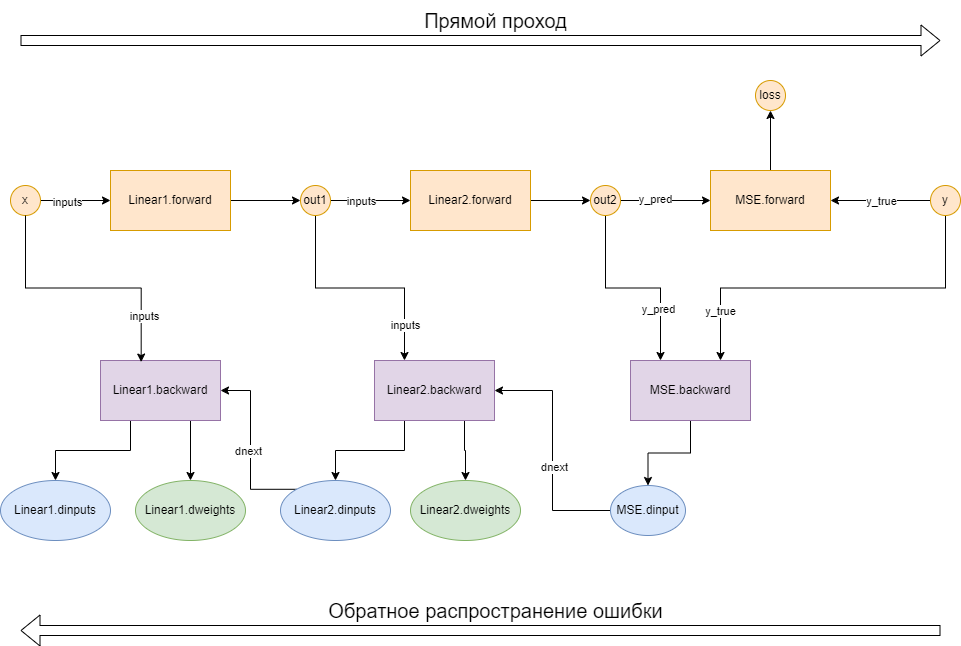

In [ ]:
import torch as th

th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

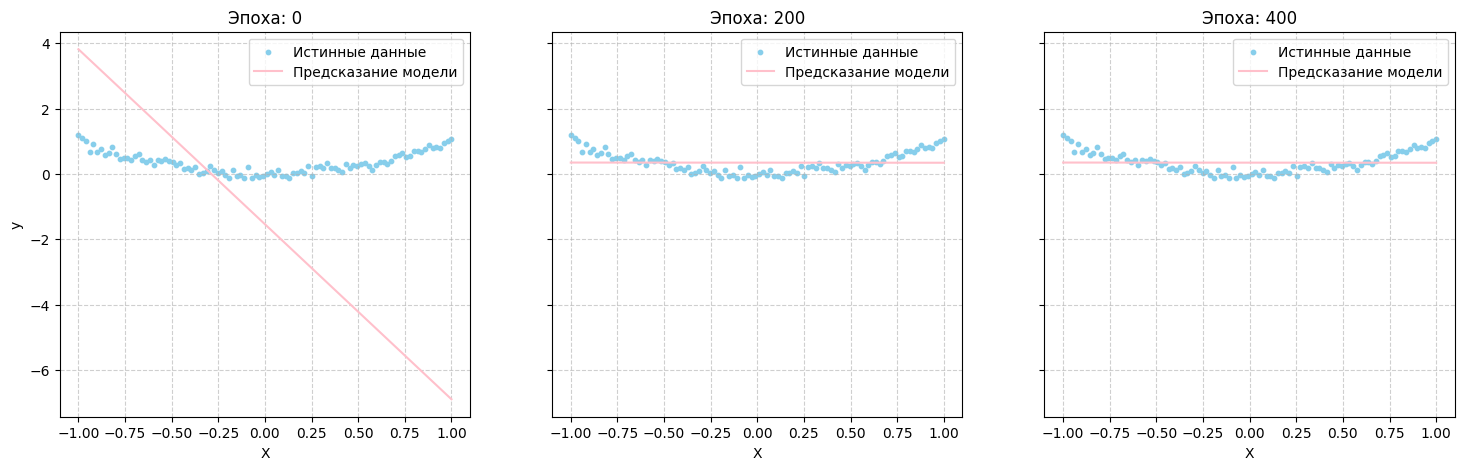

In [ ]:
import matplotlib.pyplot as plt
th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.1 * th.randn(X.size())

linear1 = Linear(n_features=1, n_neurons=10, seed=42)
linear2 = Linear(n_features=10, n_neurons=1, seed=43)
loss_fn = MSELoss()

learning_rate = 0.01
epochs = 400

predictions_history = {}
snapshot_epochs = [0, 200, 400]

for epoch in range(epochs + 1):
    out1 = linear1.forward(X)
    y_pred = linear2.forward(out1)
    loss = loss_fn.forward(y_pred, y)

    if epoch in snapshot_epochs:
        predictions_history[epoch] = y_pred.detach().clone()

    loss_fn.backward(y_pred, y)
    dinput2 = loss_fn.dinput

    linear2.backward(out1, dinput2)
    dinput1 = linear2.dinput

    linear1.backward(X, dinput1)

    with th.no_grad():
        linear1.weights -= learning_rate * linear1.dweights
        linear2.weights -= learning_rate * linear2.dweights

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, epoch in enumerate(snapshot_epochs):
    ax = axes[i]
    ax.scatter(X.numpy(), y.numpy(), s=10, color='skyblue', label='Истинные данные')
    ax.plot(X.numpy(), predictions_history[epoch].numpy(), color='pink', label='Предсказание модели')
    ax.set_title(f'Эпоха: {epoch}')
    ax.set_xlabel('X')
    if i == 0:
        ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

<p class="task" id="6"></p>

6\. Модель из предыдущей задачи является линейной и не способна качественно предсказать искомую зависимость. Для того, чтобы сделать модель нелинейной, в нейронных сетях используются функции активации. Для того, чтобы встроить такую функцию в процесс обратного распространения ошибки, необходимо реализовать соответствующий слой с методами `forward` и `backward`.

$$
f(x) = \max(0, x)
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial x} = \frac{\partial L}{\partial f}
\begin{cases}
1 & \text{если } x \ge 0 \\
0 & \text{если } x <  0
\end{cases}
$$

Здесь $L$ - это функция (слой), следующая за ReLU в потоке вычислений.

Реализуйте и обучите модель, состояющую из двух полносвязных слоев, разделенных функцией активации ReLU:
1. Полносвязный слой с 10 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).




- [ ] Проверено на семинаре

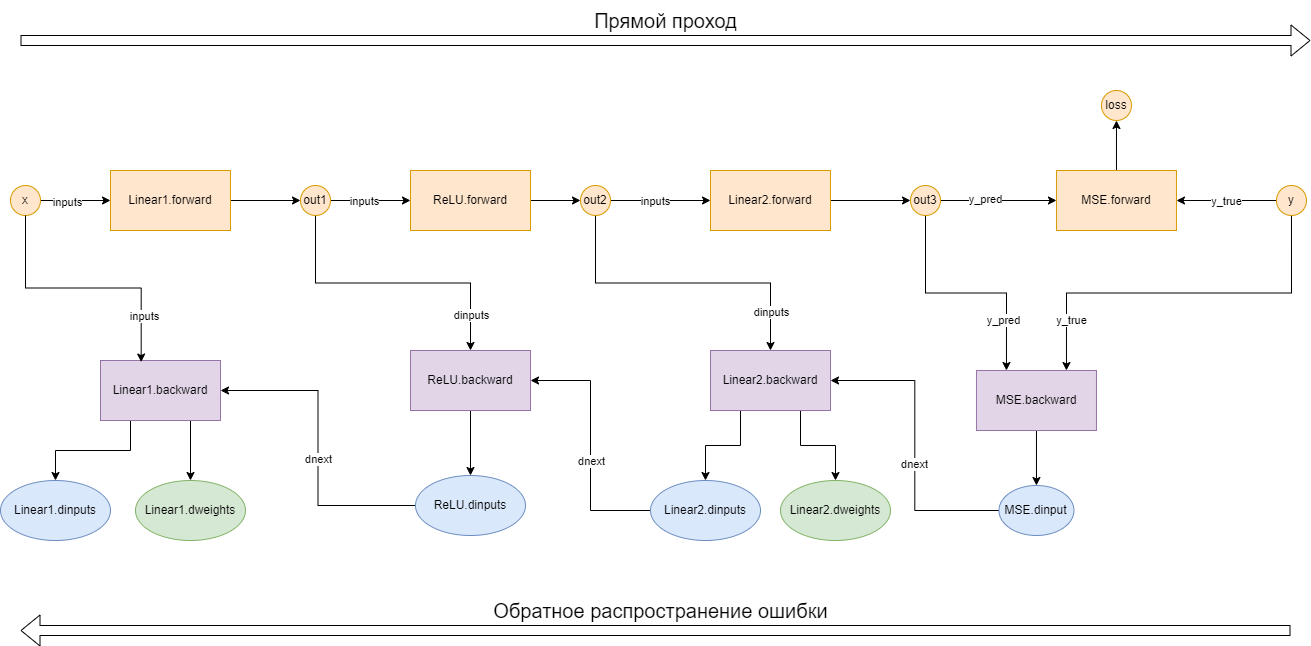

In [ ]:
class ReLU:
    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features"]:
        self.mask = (inputs > 0).to(inputs.dtype)
        return inputs * self.mask

    def backward(
        self,
        inputs: TensorType["batch", "n_features"],
        dvalues: TensorType["batch", "n_features"]
    ) -> TensorType["batch", "n_features"]:
        return dvalues * self.mask

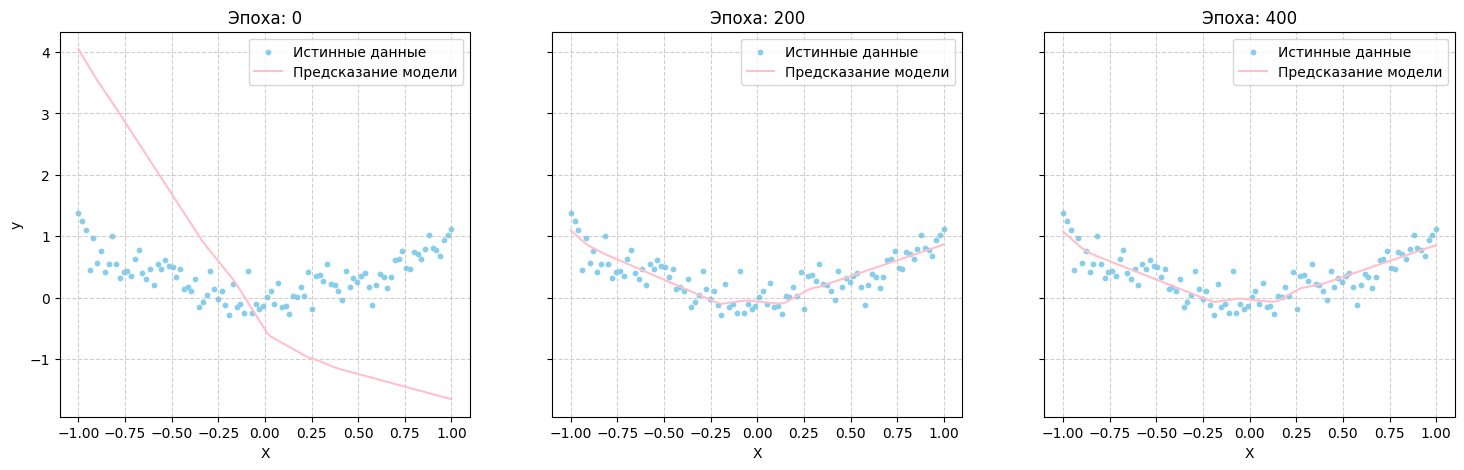

In [ ]:
th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.randn(X.size())

linear1 = Linear(n_features=1, n_neurons=10, seed=42)
activation = ReLU()
linear2 = Linear(n_features=10, n_neurons=1, seed=43)
loss_fn = MSELoss()

learning_rate = 0.02
epochs = 400

predictions_history = {}
snapshot_epochs = [0, 200, 400]

for epoch in range(epochs + 1):
    out1 = linear1.forward(X)
    activated_out1 = activation.forward(out1)
    y_pred = linear2.forward(activated_out1)
    loss = loss_fn.forward(y_pred, y)

    if epoch in snapshot_epochs:
        predictions_history[epoch] = y_pred.detach().clone()

    loss_fn.backward(y_pred, y)
    linear2.backward(activated_out1, loss_fn.dinput)
    dinput1 = activation.backward(out1, linear2.dinput)
    linear1.backward(X, dinput1)

    with th.no_grad():
        linear1.weights -= learning_rate * linear1.dweights
        linear2.weights -= learning_rate * linear2.dweights

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, epoch in enumerate(snapshot_epochs):
    ax = axes[i]
    ax.scatter(X.numpy(), y.numpy(), s=10, color='skyblue', label='Истинные данные')
    ax.plot(X.numpy(), predictions_history[epoch].numpy(), color='pink', label='Предсказание модели')
    ax.set_title(f'Эпоха: {epoch}')
    ax.set_xlabel('X')
    if i == 0:
        ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.show()